# 02 - Dimension reduction and discretization
In this notebook, we will cover how to perform dimension reduction and discretization of molecular dynamics data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma

## Case 1: preprocessed, two-dimensional data (toy model)
We load the two-dimensional trajectory from an archive using `numpy` and visualize the marginal and joint distributions of both components. In order to make the important concept of metastability easier to understand, an excerpt from the original trajectory is added.

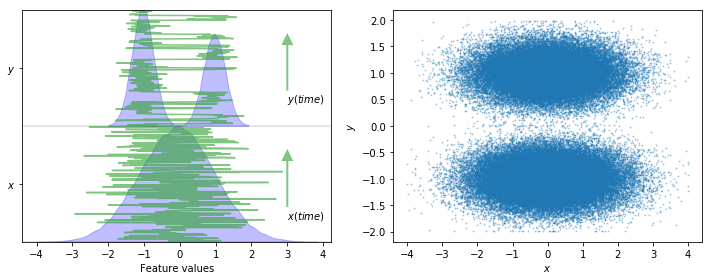

In [58]:
file = mdshare.fetch('hmm-doublewell-2d-100k.npz', working_directory='data')
with np.load(file) as fh:
    data = fh['trajectory']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(data, feature_labels=['$x$', '$y$'], ax=axes[0])
for dim in range(2): 
    axes[0].plot(data[:300, dim], np.linspace(-.2 + dim, .8 + dim, 300), color='C2', alpha=.6)
    axes[0].annotate('${}(time)$'.format('x' if dim == 0 else 'y'), xy=(3, .6 + dim), xytext=(3, dim),
            arrowprops=dict(fc='C2', ec='None', alpha=.6, width=2))

axes[1].scatter(*data.T, s=1, alpha=0.3)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
fig.tight_layout()

Given the low dimensionality of this data set, we can directly attempt to discretize, e.g. with $k$-means with $200$ centers

In [4]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=200)

22-05-18 17:35:40 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


or with a regspace technique where all centers should have a minimal pairwise distance of $0.3$ units of length

In [5]:
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.3)

and, then, we visualize both sets of centers on top of the joint distribution:

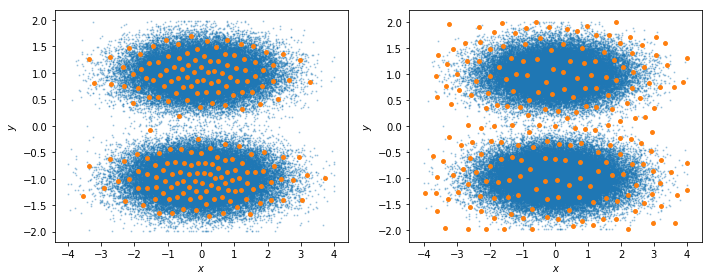

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    ax.scatter(*data.T, s=1, alpha=0.3)
    ax.scatter(*cls.clustercenters.T, s=15)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
fig.tight_layout()

Have you noticed how the $k$-means centers follow the density of the data points while the regspace centers are spread uniformly over the whole area?

The main result of a discretization, however, is not the set of centers but the timeseries of discrete states. These are accessible via the `dtrajs` attribute of any clustering object:

In [8]:
print(cluster_kmeans.dtrajs)
print(cluster_regspace.dtrajs)

[array([158,  39,  21, ...,  50, 136, 195], dtype=int32)]
[array([ 0,  1,  2, ..., 22, 18, 68], dtype=int32)]


For each trajectory passed to the clustering object, we get a corresponding discrete trajectory.

Instead of discretizing the full (two-dimensional) space, we can attempt to find a one-dimensional subspace which
1. describes the slow dynamics of the data set equally well but
2. is easier to discretize.

One widespread method for dimension reduction is the principal component analysis (PCA) which finds a subspace with maximized variance:

In [63]:
pca = pyemma.coordinates.pca(data, dim=1)
pca_out = pca.get_output()
print(pca_out)

[array([[-0.26751208],
       [ 0.37113857],
       [-0.35730326],
       ..., 
       [-0.55788803],
       [ 0.93817538],
       [-0.73651516]], dtype=float32)]


Another technique is the time-lagged independent component analysis (TICA) which finds a subspace with maximized autocorrelation:

In [64]:
tica = pyemma.coordinates.tica(data, dim=1, lag=1)
tica_out = tica.get_output()
print(tica_out)

[array([[-0.42423657],
       [-0.73914737],
       [-0.79901934],
       ..., 
       [-1.18704855],
       [-0.60901642],
       [-0.56599879]], dtype=float32)]


While there are many cases where PCA can find a suitable subspace, there are also many cases where the PCA-based subspace neglects the slow dynamics. In our example, the slow process is the jump between both wells along the $y$ axis while the $x$-axis contains only random noise. For both, PCA and TICA, we show the distribution after projecting the full dynamics onto a one-dimensional subspace (left) and the direction of projection (right).

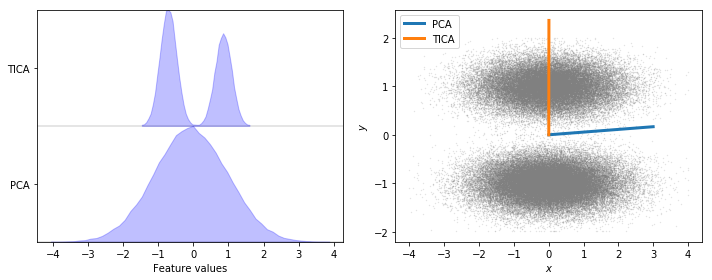

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    np.concatenate([pca_out[0], tica_out[0]], axis=1),
    feature_labels=['PCA', 'TICA'],
    ax=axes[0])
axes[1].scatter(*data.T, s=0.1, alpha=0.3, c='grey')
axes[1].plot(
    [0, 3 * abs(pca.eigenvectors[0, 0])],
    [0, 3 * abs(pca.eigenvectors[1, 0])],
    linewidth=3,
    label='PCA')
axes[1].plot(
    [0, 3 * abs(tica.eigenvectors[0, 0])],
    [0, 3 * abs(tica.eigenvectors[1, 0])],
    linewidth=3,
    label='TICA')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].legend()
fig.tight_layout()

We see that TICA projects along the $y$-axis and, thus, yields a subspace which clearly resolves both metastable states. PCA on the other hand projects closely along the $x$-axis and does not resolve both metastabel states. This is a case in point where variance maximization does not lead to a subspace which resolves the slow dynamics of the system.

This effect can also be seen when we plot the subapce timeseries:

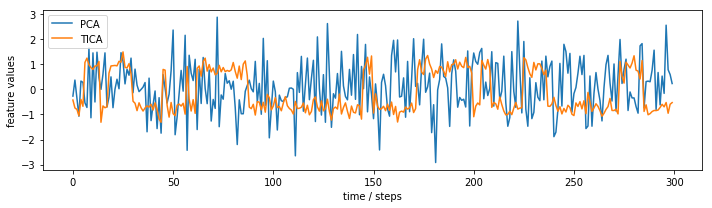

In [67]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(pca_out[0][:300], label='PCA')
ax.plot(tica_out[0][:300], label='TICA')
ax.set_xlabel('time / steps')
ax.set_ylabel('feature values')
ax.legend()
fig.tight_layout()

In case of TICA, we observe that the projected coordinate jumps between two clearly separated plateaus. For PCA, we observe only random fluctuations without any hint of metastablility.

For the discretization of both projections, we show an alternative to $k$-means and regspace clustering, the manual creation of a one-dimensional grid with uniform distance between neighbouring centers.

We first discretize the PCA projection

In [68]:
centers_pca = np.linspace(np.min(pca_out), np.max(pca_out), 50)
dtrajs_pca = pyemma.coordinates.assign_to_centers(pca_out, centers=centers_pca.reshape(-1, 1))
print(dtrajs_pca)

[array([23, 27, 22, ..., 21, 30, 20], dtype=int32)]


then the TICA projection

In [69]:
centers_tica = np.linspace(np.min(tica_out), np.max(tica_out), 50)
dtrajs_tica = pyemma.coordinates.assign_to_centers(tica_out, centers=centers_tica.reshape(-1, 1))
print(dtrajs_tica)

[array([16, 11, 11, ...,  4, 14, 14], dtype=int32)]


and, finally, we visualize the distributions of discrete states for both projections:

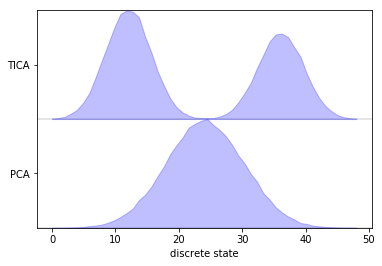

In [70]:
ax = pyemma.plots.plot_feature_histograms(
    np.concatenate([dtrajs_pca, dtrajs_tica]).T,
    feature_labels=['PCA', 'TICA'])
ax.set_xlabel('discrete state');

Again, we can see that the TICA-based discrete trajectory resolves the two metastable states whereas the PCA-based discrete trajectory does not resolve these states.

## Case 2: low-dimensional molecular dynamics data (alanine dipeptide)
We fetch the alanine dipeptide data set, load the backbone torsions into memory, and visualize the margial and joint distributions:

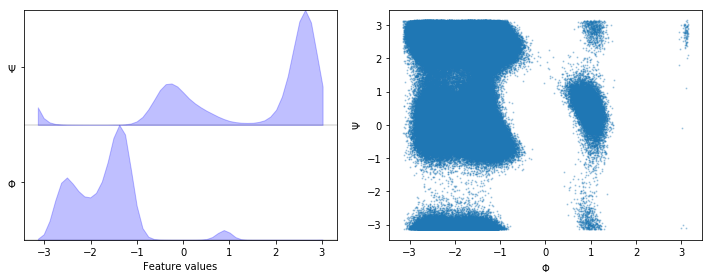

In [71]:
pdb = mdshare.fetch('alanine-dipeptide-nowater.pdb', working_directory='data')
files = mdshare.fetch('alanine-dipeptide-*-250ns-nowater.dcd', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions()
data = pyemma.coordinates.load(files, features=feat)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
axes[1].scatter(*np.concatenate(data).T, s=1, alpha=0.3)
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
fig.tight_layout()

Following the previous example, we perform a $k$-means ($200$ centers) and a regspace ($0.3$ radians center distance) on the full two-dimensional data set and visualize the obtained centers:

22-05-18 18:19:11 pyemma.coordinates.clustering.kmeans.KmeansClustering[10] INFO     Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


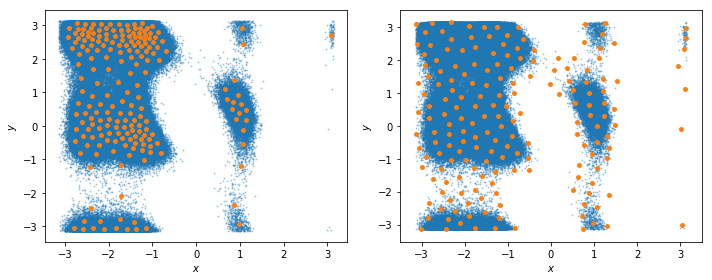

In [72]:
cluster_kmeans = pyemma.coordinates.cluster_kmeans(data, k=200)
cluster_regspace = pyemma.coordinates.cluster_regspace(data, dmin=0.3)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, cls in zip(axes.flat, [cluster_kmeans, cluster_regspace]):
    ax.scatter(*np.concatenate(data).T, s=1, alpha=0.3)
    ax.scatter(*cls.clustercenters.T, s=15)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
fig.tight_layout()

Again, notice the difference between $k$-means and regspace clustering.

Now, we use a different featurization for the same data set and revisit how to use PCA and TICA.

**Exercise**: Load the heavy atoms' positions into memory.

We have 30 features.


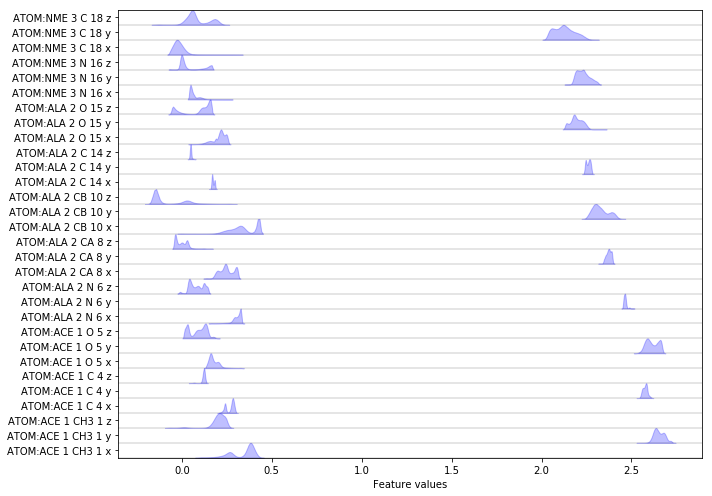

In [73]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_selection(feat.select_Heavy())
data = pyemma.coordinates.load(files, features=feat)

print('We have %d features.' % feat.dimension())

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=feat.describe(), ax=ax)
fig.tight_layout()

Discretizing a $30$-dimensional feature space is impractical. Let's use PCA to find a low-dimensional projection and visualize the marginal distributions of all principal components (PCs) as well as the joint distributions for the first two PCs:

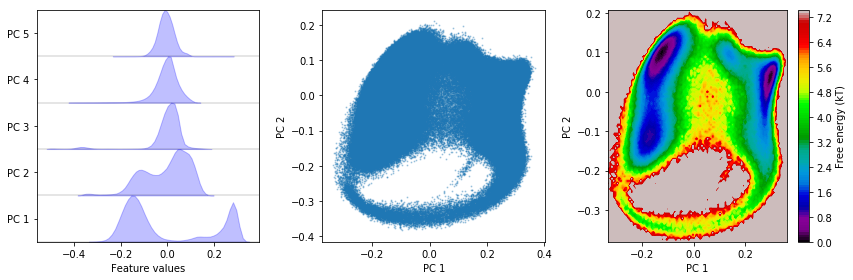

In [74]:
pca = pyemma.coordinates.pca(data)
pca_all = np.concatenate(pca.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pyemma.plots.plot_feature_histograms(
    pca_all, ['PC %d' % (i + 1) for i in range(pca.dimension())], ax=axes[0])
axes[1].scatter(*pca_all[:, :2].T, s=1, alpha=0.3)
pyemma.plots.plot_free_energy(*pca_all[:, :2].T, ax=axes[2])
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

With the default parameters, PCA will return as many dimensions as necessary to explain $95\%$ of the variance; in this case, we have found a five-dimensional subspace which does seem to resolve some metastability in the first three principal components.

**Exercise**: apply TICA and visualize the marginal distributions of all independent components (ICs) as well as the joint distributions of the first two ICs.

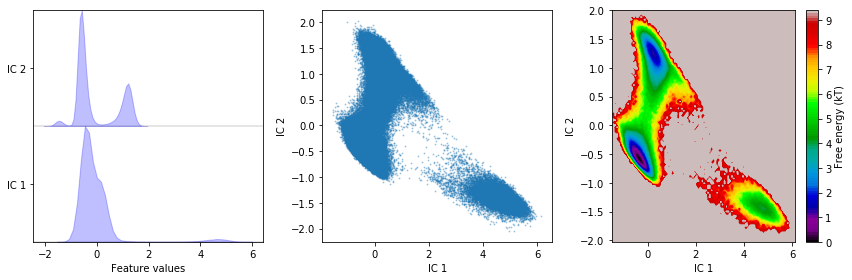

In [75]:
tica = pyemma.coordinates.tica(data)
tica_all = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pyemma.plots.plot_feature_histograms(
    tica_all, ['IC %d' % (i + 1) for i in range(tica.dimension())], ax=axes[0])
axes[1].scatter(*tica_all[:, :2].T, s=1, alpha=0.3)
pyemma.plots.plot_free_energy(*tica_all[:, :2].T, ax=axes[2])
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

TICA, by default, uses a lag time of $10$ steps and a kinetic variance cutoff of $95\%$ to determine the number of ICs. We observe that this projection does resolve some metastability in both ICs.

Whether these projections are suitable for building Markov state models, though, remains to be seen in later tests.

**Exercise**: Perform PCA on the heavy atoms' positions data set with a target dimension of two; then discretize the two-dimensional subspace using $k$-means with $200$ centers.

**Hint:** Look up the parameters of `pyemma.coordinates.pca()`, especially the `dim` parameter.

22-05-18 18:23:13 pyemma.coordinates.clustering.kmeans.KmeansClustering[22] INFO     Cluster centers converged after 39 steps.


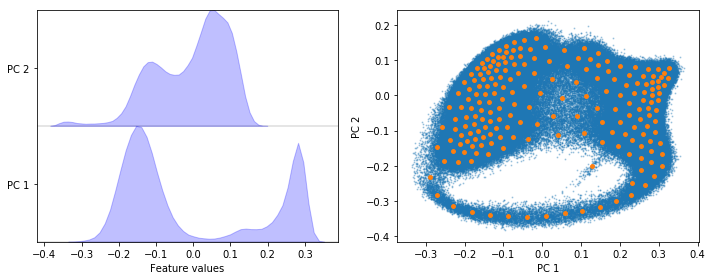

In [76]:
pca = pyemma.coordinates.pca(data, dim=2)
pca_all = np.concatenate(pca.get_output())

cluster = pyemma.coordinates.cluster_kmeans(pca, k=200, max_iter=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    pca_all, ['PC %d' % (i + 1) for i in range(pca.dimension())], ax=axes[0])
axes[1].scatter(*pca_all.T, s=1, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15)
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
fig.tight_layout()

**Exercise**: Perform TICA at lag time $1$ step on the heavy atoms' positions data set with a target dimension of two; then discretize the two-dimensional subspace using $k$-means with $200$ centers.

**Hint:** Look up the parameters of `pyemma.coordinates.tica()`, especially the `dim` and `lag` parameters.

22-05-18 18:26:23 pyemma.coordinates.clustering.kmeans.KmeansClustering[26] INFO     Cluster centers converged after 5 steps.


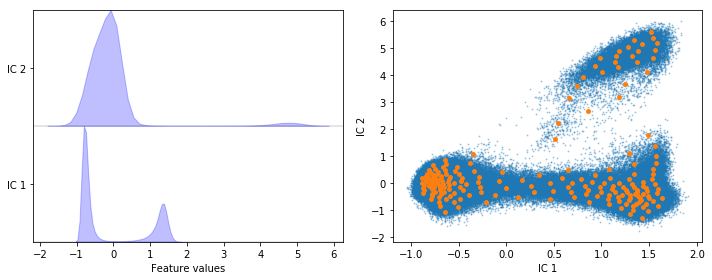

In [77]:
tica = pyemma.coordinates.tica(data, lag=1, dim=2)
tica_all = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k=200, max_iter=50)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_all, ['IC %d' % (i + 1) for i in range(tica.dimension())], ax=axes[0])
axes[1].scatter(*tica_all.T, s=1, alpha=0.3)
axes[1].scatter(*cluster.clustercenters.T, s=15)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

Have you noticed the difference in the first two ICs for lag times $10$ steps vs $1$ step?

## Case 3: another molecular dynamics data set (pentapeptide)

**Exercise**: Fetch the pentapeptide data set, load the cossin transformations of the backbone and $\chi_1$ sidechain torsions into memory, and visualize the margial distributions:

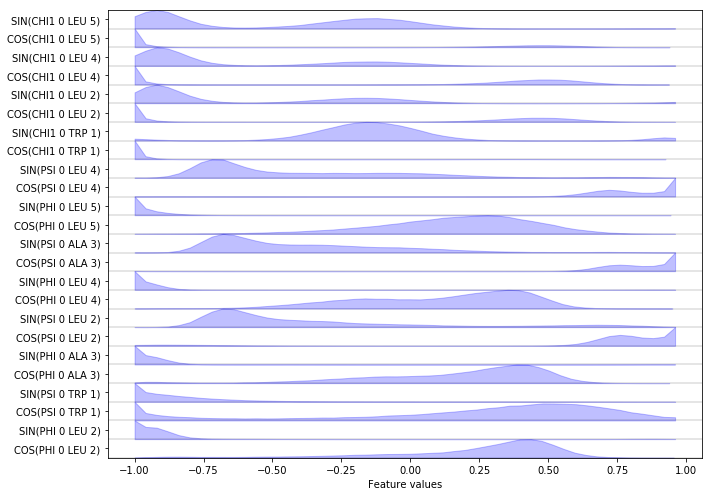

In [78]:
pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(cossin=True)
feat.add_sidechain_torsions(which='chi1', cossin=True)

data = pyemma.coordinates.load(files, features=feat)

fig, ax = plt.subplots(figsize=(10, 7))
pyemma.plots.plot_feature_histograms(np.concatenate(data), feature_labels=feat.describe(), ax=ax)
fig.tight_layout()

**Exercise**: Perform PCA with default parameters and visualize the marginal distributions of all PCs and the joint distributions of the first two PCs.

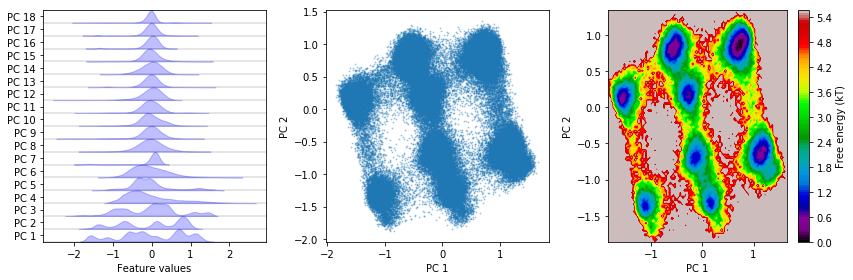

In [79]:
pca = pyemma.coordinates.pca(data)
pca_all = np.concatenate(pca.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pyemma.plots.plot_feature_histograms(
    pca_all, ['PC %d' % (i + 1) for i in range(pca.dimension())], ax=axes[0])
axes[1].scatter(*pca_all[:, :2].T, s=1, alpha=0.3)
pyemma.plots.plot_free_energy(*pca_all[:, :2].T, ax=axes[2])
for ax in axes.flat[1:]:
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
fig.tight_layout()

**Exercise**: Perform TICA with the lag times given below and, for each lag time, visualize the marginal distributions of all ICs and the joint distributions of the first two ICs.

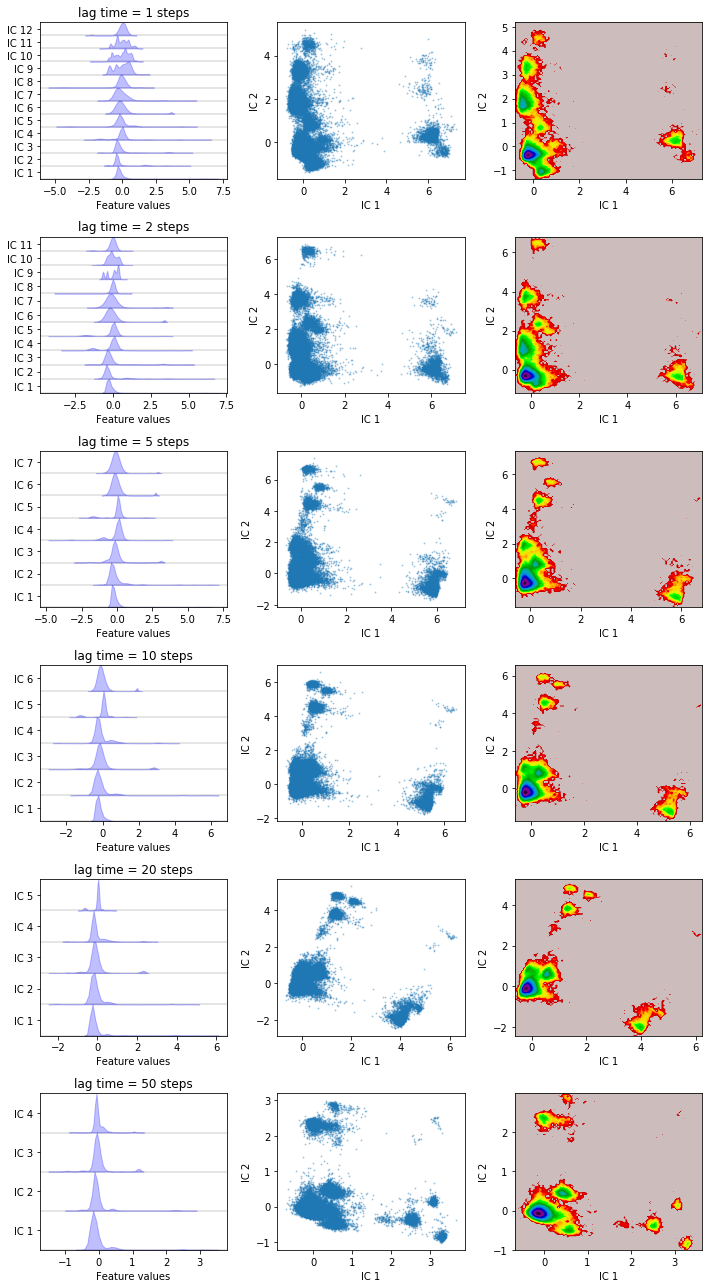

In [80]:
lags = [1, 2, 5, 10, 20, 50]

fig, axes = plt.subplots(len(lags), 3, figsize=(10, len(lags) * 3))
for i, lag in enumerate(lags):
    tica = pyemma.coordinates.tica(data, lag=lag)
    tica_all = np.concatenate(tica.get_output())
    pyemma.plots.plot_feature_histograms(
        tica_all, ['IC %d' % (i + 1) for i in range(tica.dimension())], ax=axes[i, 0])
    axes[i, 0].set_title('lag time = %d steps' % lag)
    axes[i, 1].scatter(*tica_all[:, :2].T, s=1, alpha=0.3)
    pyemma.plots.plot_free_energy(*tica_all[:, :2].T, ax=axes[i, 2], cbar=False)
for ax in axes[:, 1:].flat:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

Have you noticed that increasing the lag time
1. leads to a rotation of the projection and
2. reduces the number of ICs to explain $95\%$ (default) of the kinetic variance?

Note that, while we can get lower and lower dimensional subspaces with increased lag times, we also loose information from the faster processes.

How to choose the optimal lag time for a TICA projection often is a hard problem, but we will learn systematic approaches in later notebooks.

**Exercise**: Perform PCA with target dimension $3$ on the current feature set and discretize the projected space using $k$-means with $200$ centers and a stride of $5$ to reduce the computational effort.

22-05-18 18:31:44 pyemma.coordinates.clustering.kmeans.KmeansClustering[50] INFO     Cluster centers converged after 7 steps.


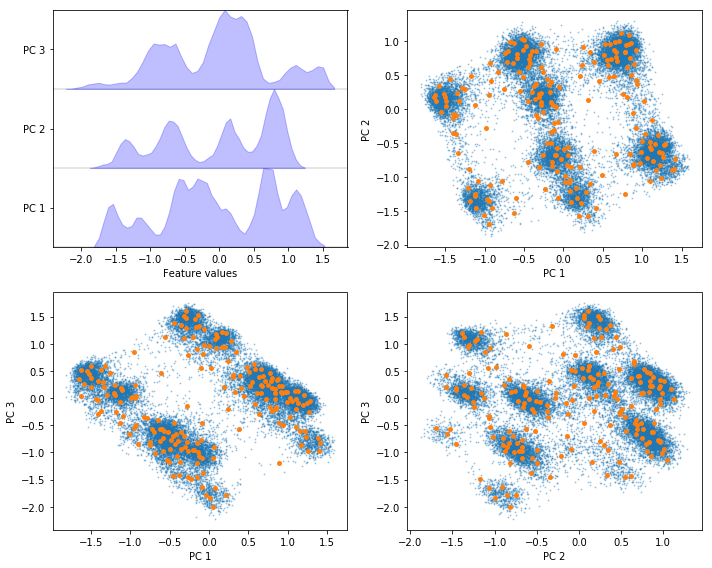

In [81]:
pca = pyemma.coordinates.pca(data, dim=3)
pca_all = np.concatenate(pca.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(pca, k=200, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    pca_all, ['PC %d' % (i + 1) for i in range(pca.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [0, 2], [1, 2]]):
    ax.scatter(*pca_all[:, [i, j]].T, s=1, alpha=0.3)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15)
    ax.set_xlabel('PC %d' % (i + 1))
    ax.set_ylabel('PC %d' % (j + 1))
fig.tight_layout()

**Exercise**: Perform TICA with target dimension $3$ and lag time $20$ steps on the curent feature set and discretize the projected space using $k$-means with $200$ centers and a stride of $5$ to reduce the computational effort.

22-05-18 18:32:53 pyemma.coordinates.clustering.kmeans.KmeansClustering[54] INFO     Cluster centers converged after 6 steps.


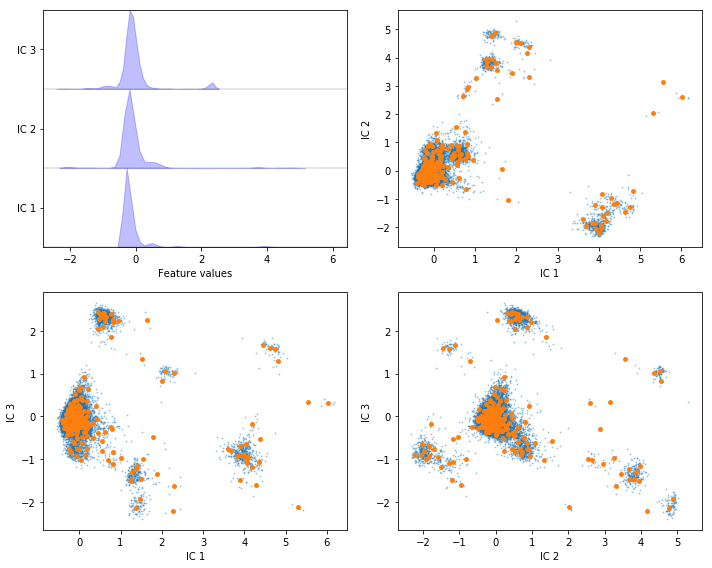

In [82]:
tica = pyemma.coordinates.tica(data, lag=20, dim=3)
tica_all = np.concatenate(tica.get_output(stride=5))

cluster = pyemma.coordinates.cluster_kmeans(tica, k=200, max_iter=50, stride=5)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
pyemma.plots.plot_feature_histograms(
    tica_all, ['IC %d' % (i + 1) for i in range(tica.dimension())], ax=axes[0, 0])
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [0, 2], [1, 2]]):
    ax.scatter(*tica_all[:, [i, j]].T, s=1, alpha=0.3)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=15)
    ax.set_xlabel('IC %d' % (i + 1))
    ax.set_ylabel('IC %d' % (j + 1))
fig.tight_layout()

## Wrapping up
In this notebook, we have learned how to reduce the dimension of molecular simulation data and discretize the projected dynamics with `pyemma`. In detail, we have used
- `pyemma.coordinates.pca()` to perform a principal components analysis,
- `pyemma.coordinates.tica()` to perform a time-lagged independent component analysis, and
- `pyemma.coordinates.cluster_kmeans()` to perform a $k$-means clustering,
- `pyemma.coordinates.cluster_regspace()` to perform a regspace clustering, and
- `pyemma.coordinates.assign_to_centers()` to map trajectories to user-defined centers.